In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
import pickle
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
from abc import ABC, abstractmethod

from cubic_subproblem_solver import *

# Helper functions

In [2]:
def get_principal_vecs(X, new_dim):
    assert new_dim <= X.shape[1]
    sigma, V = torch.linalg.eigh(X.T @ X)
    princ_vecs = V[:,-new_dim:]
    return princ_vecs


def load_and_transform_mnist(new_dim):
    mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
    mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
    
    X_train = mnist_trainset.data.reshape(-1,28*28) / 255.
    y_train = mnist_trainset.targets
    X_test = mnist_testset.data.reshape(-1,28*28) / 255.
    y_test = mnist_testset.targets
    
    princ_vecs = get_principal_vecs(X_train, new_dim)
    X_train = X_train @ princ_vecs
    X_test = X_test @ princ_vecs
    
    mnist_dataset = {
        "train_data": X_train,
        "train_targets": y_train,
        "test_data": X_test,
        "test_targets": y_test
    }
    
    return mnist_dataset


def transform_labels_to_binary(labels):
    return torch.tensor(list(map(lambda x: 0 if x<5 else 1, labels)))


class LogisticNet(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)


class MLP(nn.Module):
    
    def __init__(self, dims, activation):
        super().__init__()
        assert len(dims) >= 2
        self.activation = activation
        self.n_layers = len(dims) - 1
        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))
    
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[self.n_layers - 1](x)


# Abstract class Trainer

In [3]:
class Trainer(ABC):
    
    def __init__(self, model, dataset, criterion):
        
        self.model = model
        self.dataset = dataset
        self.criterion = criterion
        
        self.metrics = {}
        self.initialize_metrics()
    
    def initialize_metrics(self):
        # TODO: add step distance
        self.metrics = {
            "train_loss": [],
            "test_loss": [],
            "train_acc": [],
            "test_acc": [],
            "grad_norm": [],
            "time": [],
            "iter": [],
            "lambda_1": [],
            "lambda_n": [],
            "hessian_iter": []
        }
    
    def evaluate(self, X, y):
        with torch.no_grad():
            preds = self.model(X)
            loss = self.criterion(preds, y)
            preds = torch.argmax(preds, axis=1)
            acc = torch.mean((preds == y).float())
        return loss.item(), acc.item()
    
    def calculate_grad_norm_squared(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        self.model.zero_grad()
        loss.backward()
        grad_norm = sum([p.grad.pow(2).sum() for p in self.model.parameters()])
        return grad_norm
    
    def calculate_hessian(self, X, y):
        
        def calculate_loss(*params):
            assert len(params) % 2 == 0
            n_layers = len(params) // 2
            preds = X
            for i in range(n_layers):
                preds = preds @ params[2*i].T + params[2*i+1]
            return self.criterion(preds, y)

        params = tuple([p.data for p in self.model.parameters()])
        hessians = torch.autograd.functional.hessian(calculate_loss, params)
        
        hessians = list(hessians)
        n = len(hessians)
        for i in range(n):
            hessians[i] = list(hessians[i])

        params_numels = [p.data.numel() for p in self.model.parameters()]

        for i in range(n):
            for j in range(n):
                hessians[i][j] = hessians[i][j].reshape(params_numels[i], params_numels[j])
            hessians[i] = torch.cat(hessians[i], axis=1)

        hessians = torch.cat(hessians, axis=0)

        return hessians
    
    def update_metrics(self, iteration, training_time, eval_hessian, grad_norm=None, hessian=None):
        # iteration = 0 if len(self.metrics["iter"]) == 0 else self.metrics["iter"][-1] + 1
        tr_loss, tr_acc = self.evaluate(self.dataset["train_data"], self.dataset["train_targets"])
        tst_loss, tst_acc = self.evaluate(self.dataset["test_data"], self.dataset["test_targets"])
        
        if grad_norm is None:
            grad_norm = math.sqrt(self.calculate_grad_norm_squared(
                self.dataset["train_data"], self.dataset["train_targets"]))
        
        self.metrics["train_loss"].append(tr_loss)
        self.metrics["test_loss"].append(tst_loss)
        self.metrics["train_acc"].append(tr_acc)
        self.metrics["test_acc"].append(tst_acc)
        self.metrics["grad_norm"].append(grad_norm)
        self.metrics["time"].append(training_time)
        self.metrics["iter"].append(iteration)
        
        if eval_hessian:
            if hessian is None:
                hessian = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
            hessian = hessian.numpy()
            w = np.linalg.eigvalsh(hessian)
            self.metrics["hessian_iter"].append(iteration)
            self.metrics["lambda_1"].append(w[-1])
            self.metrics["lambda_n"].append(w[0])
    
    def afterprocess_metrics(self, max_time):
        assert len(self.metrics["time"]) > 0
        if self.metrics["time"][-1] > max_time:
            for key in self.metrics.keys():
                self.metrics[key].pop()
    
    @abstractmethod
    def print_training_stats(metrics, iteration):
        pass
    
    @abstractmethod
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every, eval_hessian_every):
        pass
    
    def train(self, max_iters=None, max_time=None, print_every=None, eval_every=None, eval_hessian_every=None):
        # every time we want to print metrics, it must be evaluated
        assert (print_every == None) or ((eval_every is not None) and (print_every % eval_every == 0))
        assert max_iters != None or max_time != None
        if max_iters == None:
            max_iters = float('inf')
        if max_time == None:
            max_time = float('inf')
        
        # calculate metrics for initial model state
        if (len(self.metrics["iter"]) == 0) and (eval_every != None):
            self.update_metrics(0, training_time=0.0, eval_hessian=eval_hessian_every is not None)
        
        if print_every != None:
            self.__class__.print_training_stats(self.metrics, 0)
        
        self.perform_training_loop(max_iters, max_time, print_every, eval_every, eval_hessian_every)

        self.afterprocess_metrics(max_time)
        return self.metrics.copy()

# GD with adaptive L as child class

In [4]:
class AdaptiveGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, L_0, L_min):
        
        self.L = L_0
        self.L_min = L_min
        super().__init__(model, dataset, criterion)
        # maintaining current gradient norm as attribute to avoid extra computation
        self.grad_norm_squared = self.calculate_grad_norm_squared(
            self.dataset["train_data"], self.dataset["train_targets"])
    
    def initialize_metrics(self):
        super().initialize_metrics()
        self.metrics["L"] = []
    
    def update_metrics(self, iteration, training_time, eval_hessian):
        grad_norm = math.sqrt(self.grad_norm_squared)
        super().update_metrics(iteration, training_time, eval_hessian, grad_norm=grad_norm)
        self.metrics["L"].append(self.L)
    
    def print_training_stats(metrics, iteration):
        if (iteration in metrics["iter"]):
            iter_id = metrics["iter"].index(iteration)
            print(f'{metrics["iter"][iter_id]:>6,d}: train loss = {metrics["train_loss"][iter_id]:>9.6f}, \
L = {metrics["L"][iter_id]:>8.3f}, time = {metrics["time"][iter_id]:>7.2f} sec', end='')
        if (iteration in metrics["hessian_iter"]):
            hess_iter_id = metrics["hessian_iter"].index(iteration)
            print(f', lambda_1 = {metrics["lambda_1"][hess_iter_id]:>12.5f},', end=' ')
            print(f'lambda_n = {metrics["lambda_n"][hess_iter_id]:>12.6f}', end='')
        print()
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def set_params(self, another_model, new_params):
        for p, d in zip(another_model.parameters(), new_params):
            p.data = d
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every, eval_hessian_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            
            outputs = self.model(self.dataset["train_data"])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"])
            loss.backward()
            model_next = copy.deepcopy(self.model)
            new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
            self.set_params(model_next, new_params)
            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                    loss.item() - 1/(2*self.L) * self.grad_norm_squared):
                self.L *= 2
                new_params = [p.data - 1/self.L * p.grad for p in self.model.parameters()]
                self.set_params(model_next, new_params)
            self.set_params(self.model, new_params)
            self.grad_norm_squared = self.calculate_grad_norm_squared(
                self.dataset["train_data"], self.dataset["train_targets"])
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                eval_hessian = (eval_hessian_every is not None) and ((i+1) % eval_hessian_every == 0)
                self.update_metrics(i+1, total_time, eval_hessian)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, i+1)
                start_time = time.perf_counter()
            self.L = max(self.L / 2, self.L_min)
            i += 1
        

# Cubic Newton with adaptive M as child class

In [5]:
class AdaptiveCubicNewtonTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, M_0, M_min):
        
        self.M = M_0
        self.M_min = M_min
        super().__init__(model, dataset, criterion)
        # maintaining as attributes to avoid extra computation
        self.gradient = self.calculate_gradient(self.dataset["train_data"], self.dataset["train_targets"])
        self.hessian = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
    
    def initialize_metrics(self):
        super().initialize_metrics()
        self.metrics["M"] = []
    
    def update_metrics(self, iteration, training_time, eval_hessian):
        grad_norm = self.gradient.pow(2).sum().sqrt().item()
        hessian = self.hessian
        super().update_metrics(iteration, training_time, eval_hessian, grad_norm, hessian)
        self.metrics["M"].append(self.M)
    
    def print_training_stats(metrics, iteration):
        if iteration in metrics["iter"]:
            iter_id = metrics["iter"].index(iteration)
            print(f'{metrics["iter"][iter_id]:>6,d}: train loss = {metrics["train_loss"][iter_id]:>9.6f}, \
M = {metrics["M"][iter_id]:>8.3f}, time = {metrics["time"][iter_id]:>7.2f} sec', end='')
        if (iteration in metrics["hessian_iter"]):
            hess_iter_id = metrics["hessian_iter"].index(iteration)
            print(f', lambda_1 = {metrics["lambda_1"][hess_iter_id]:>12.5f},', end=' ')
            print(f'lambda_n = {metrics["lambda_n"][hess_iter_id]:>12.6f}', end='')
        print()
    
    def calculate_loss(self, another_model, X, y):
        with torch.no_grad():
            preds = another_model(X)
            loss = self.criterion(preds, y)
        return loss.item()
    
    def calculate_gradient(self, X, y):
        preds = self.model(X)
        loss = self.criterion(preds, y)
        gradients = torch.autograd.grad(loss, self.model.parameters())
        grad = torch.cat([g.flatten() for g in gradients], dim=0)
        return grad
    
    def quadratic_form(self, loss, grad, hess, M, h):
        return loss + torch.dot(grad,h) + 0.5 * torch.dot(hess @ h, h) + M/6 * torch.linalg.norm(h,2)**3
    
    def update_model_params(self, another_model, delta):
        params_numels = [p.data.numel() for p in another_model.parameters()]
        t = list(torch.split(delta, params_numels))
        for i, p in enumerate(another_model.parameters()):
            p.data += t[i].reshape(p.data.shape)
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every, eval_hessian_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            
            loss = self.calculate_loss(self.model, self.dataset["train_data"], self.dataset["train_targets"])
            grad = self.gradient
            hess = self.hessian
            h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
            model_next = copy.deepcopy(self.model)
            self.update_model_params(model_next, h)

            while (self.calculate_loss(model_next, self.dataset["train_data"], self.dataset["train_targets"]) > 
                self.quadratic_form(loss, grad, hess, self.M, h)):
                self.M *= 2
                h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), self.M))
                for p, p_next in zip(self.model.parameters(), model_next.parameters()):
                    p_next.data = p.data.clone()
                self.update_model_params(model_next, h)

            self.update_model_params(self.model, h)
            self.gradient = self.calculate_gradient(self.dataset["train_data"], self.dataset["train_targets"])
            self.hessian = self.calculate_hessian(self.dataset["train_data"], self.dataset["train_targets"])
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                eval_hessian = (eval_hessian_every is not None) and ((i+1) % eval_hessian_every == 0)
                self.update_metrics(i+1, total_time, eval_hessian)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, i+1)
                start_time = time.perf_counter()
            
            self.M = max(self.M / 2, self.M_min)
            i += 1


# SGD with decaying lr as 1/sqrt(t)

In [6]:
class SGDTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, initial_lr, batch_size):
        
        self.initial_lr = initial_lr
        self.lr = initial_lr
        self.batch_size = batch_size
        super().__init__(model, dataset, criterion)
    
    def print_training_stats(metrics, iteration):
        if iteration in metrics["iter"]:
            iter_id = metrics["iter"].index(iteration)
            print(f'{metrics["iter"][iter_id]:>6,d}: train loss = {metrics["train_loss"][iter_id]:>9.6f}, \
time = {metrics["time"][iter_id]:>7.2f} sec', end='')
        if (iteration in metrics["hessian_iter"]):
            hess_iter_id = metrics["hessian_iter"].index(iteration)
            print(f', lambda_1 = {metrics["lambda_1"][hess_iter_id]:>12.5f},', end=' ')
            print(f'lambda_n = {metrics["lambda_n"][hess_iter_id]:>12.6f}', end='')
        print()
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every, eval_hessian_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        batch_start = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            batch_end = batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][batch_start:batch_end])
            self.model.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][batch_start:batch_end])
            loss.backward()
            with torch.no_grad():
                for p in self.model.parameters():
                    p.data -= self.lr * p.grad
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                eval_hessian = (eval_hessian_every is not None) and ((i+1) % eval_hessian_every == 0)
                self.update_metrics(i+1, total_time, eval_hessian)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, i+1)
                start_time = time.perf_counter()
            
            batch_start = batch_end if (batch_end < self.dataset["train_data"].shape[0]) else 0
            i += 1
            self.lr = self.initial_lr / math.sqrt(i+1)


# Trainer with custom optimizer

In [7]:
class CustomTrainer(Trainer):
    
    def __init__(self, model, dataset, criterion, OptimizerClass, optimizer_params, batch_size):
        
        super().__init__(model, dataset, criterion)
        self.optimizer = OptimizerClass(self.model.parameters(), **optim_params)
        self.batch_size = batch_size
    
    def print_training_stats(metrics, iteration):
        if iteration in metrics["iter"]:
            iter_id = metrics["iter"].index(iteration)
            print(f'{metrics["iter"][iter_id]:>6,d}: train loss = {metrics["train_loss"][iter_id]:>9.6f}, \
time = {metrics["time"][iter_id]:>7.2f} sec', end='')
        if (iteration in metrics["hessian_iter"]):
            hess_iter_id = metrics["hessian_iter"].index(iteration)
            print(f', lambda_1 = {metrics["lambda_1"][hess_iter_id]:>12.5f},', end=' ')
            print(f'lambda_n = {metrics["lambda_n"][hess_iter_id]:>12.6f}', end='')
        print()
    
    def perform_training_loop(self, max_iters, max_time, print_every, eval_every, eval_hessian_every):
        start_time = time.perf_counter()
        total_time = self.metrics["time"][-1]
        i = self.metrics["iter"][-1]
        batch_start = 0
        while (i < max_iters and self.metrics["time"][-1] < max_time):
            batch_end = batch_start + self.batch_size
            outputs = self.model(self.dataset["train_data"][batch_start:batch_end])
            self.optimizer.zero_grad()
            loss = self.criterion(outputs, self.dataset["train_targets"][batch_start:batch_end])
            loss.backward()
            self.optimizer.step()
            
            if (i+1) % eval_every == 0:
                total_time += time.perf_counter() - start_time
                eval_hessian = (eval_hessian_every is not None) and ((i+1) % eval_hessian_every == 0)
                self.update_metrics(i+1, total_time, eval_hessian)
                if print_every != None and (i+1) % print_every == 0:
                    self.__class__.print_training_stats(self.metrics, i+1)
                start_time = time.perf_counter()
            
            batch_start = batch_end if (batch_end < self.dataset["train_data"].shape[0]) else 0
            i += 1


# Experiments

In [8]:
def dict_lists_to_ndarrays(metrics):
    for key, value in metrics.items():
        metrics[key] = np.array(value)
    return metrics

def print_training_stats(TrainerClass, metrics, print_every):
    if print_every != None:
        for i in range(0, len(metrics["iter"])):
            if metrics["iter"][i] % print_every == 0:
                TrainerClass.print_training_stats(metrics, i)

def train(TrainerClass, get_net_fn, get_dataset_fn, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, **kwargs):
    try:
        if retrain:
            raise FileNotFoundError

        with open(os.path.join(PATH, results_file), "rb") as f:
            metrics = pickle.load(f)
        print("Training statistics was already calculated before:\n")
        print_training_stats(TrainerClass, metrics, print_every)
    except:
        print("Retraining model:\n")
        net = get_net_fn()
        dataset = get_dataset_fn()
        trainer = TrainerClass(net, dataset, loss_function, **kwargs)
        metrics = trainer.train(max_iters, print_every=print_every, eval_every=eval_every, 
                                eval_hessian_every=eval_hessian_every)
        with open(os.path.join(PATH, results_file), "wb") as f:
            pickle.dump(metrics, f)
    return dict_lists_to_ndarrays(metrics)

### Logistic regression

In [9]:
PATH = os.path.join(os.getcwd(), "saved_calc\\logistic_regression")

if not os.path.isdir(PATH):
    os.makedirs(PATH)

In [10]:
new_dim = 20

net = LogisticNet(new_dim, 10)

loss_function = nn.CrossEntropyLoss()

MIN_TRAIN_LOSS = 0.4153611660003662 # for model = LogisticNet(20,10)
MIN_TEST_LOSS = 0.3710212409496307 # for model = LogisticNet(20,10)

def get_net():
    return copy.deepcopy(net)

def get_dataset():
    return load_and_transform_mnist(new_dim)

In [11]:
results_file = "SGD_metrics.pkl"
max_iters = 20
print_every = 10
eval_every = 1
eval_hessian_every = 10
retrain = True
# kwargs
init_lr = 1.0
b_size = 128

SGD_metrics = train(SGDTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, initial_lr=init_lr, batch_size=b_size)

Retraining model:

     0: train loss =  2.694088, time =    0.00 sec, lambda_1 =      6.76198, lambda_n =    -0.000000
    10: train loss =  0.881579, time =    0.01 sec, lambda_1 =      4.28692, lambda_n =    -0.000000
    20: train loss =  0.745783, time =    0.02 sec, lambda_1 =      3.32657, lambda_n =    -0.000000


In [12]:
results_file = "SGD_const_lr_metrics.pkl"
max_iters = 300
print_every = 30
eval_every = 1
eval_hessian_every = 10
retrain = False
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
b_size = 128

SGD_const_lr_metrics = train(CustomTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, OptimizerClass=optim_class,
                             optimizer_params=optim_params, batch_size=b_size)

Training statistics was already calculated before:

     0: train loss =  2.840061, time =    0.00 sec, lambda_1 =      8.12315, lambda_n =    -0.000000
    30: train loss =  1.115523, time =    0.02 sec, lambda_1 =      4.56631, lambda_n =    -0.000000
    60: train loss =  0.820620, time =    0.04 sec, lambda_1 =      3.83900, lambda_n =    -0.000000
    90: train loss =  0.709362, time =    0.07 sec, lambda_1 =      3.50480, lambda_n =    -0.000000
   120: train loss =  0.649055, time =    0.09 sec, lambda_1 =      3.22941, lambda_n =    -0.000000
   150: train loss =  0.608059, time =    0.11 sec, lambda_1 =      3.14454, lambda_n =    -0.000000
   180: train loss =  0.584264, time =    0.14 sec, lambda_1 =      3.03813, lambda_n =    -0.000000
   210: train loss =  0.561856, time =    0.16 sec, lambda_1 =      2.93705, lambda_n =    -0.000000
   240: train loss =  0.544727, time =    0.19 sec, lambda_1 =      2.74403, lambda_n =    -0.000000
   270: train loss =  0.530727, time = 

In [13]:
results_file = "GD_metrics.pkl"
max_iters = 300
print_every = 30
eval_every = 1
eval_hessian_every = 10
retrain = False
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

GD_metrics = train(AdaptiveGDTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, L_0=Lipschitz_const, L_min=Lipschitz_const_min)

Training statistics was already calculated before:

     0: train loss =  2.840061, L =    1.000, time =    0.00 sec, lambda_1 =      8.12315, lambda_n =    -0.000000
    30: train loss =  0.549492, L =    1.000, time =    1.90 sec, lambda_1 =      2.80004, lambda_n =    -0.000000
    60: train loss =  0.476406, L =    0.500, time =    3.79 sec, lambda_1 =      2.34117, lambda_n =    -0.000000
    90: train loss =  0.452021, L =    1.000, time =    5.70 sec, lambda_1 =      2.15801, lambda_n =    -0.000000
   120: train loss =  0.436630, L =    0.500, time =    7.92 sec, lambda_1 =      2.03607, lambda_n =    -0.000000
   150: train loss =  0.431615, L =    1.000, time =   10.48 sec, lambda_1 =      1.99323, lambda_n =    -0.000000
   180: train loss =  0.428004, L =    1.000, time =   12.67 sec, lambda_1 =      1.95249, lambda_n =    -0.000000
   210: train loss =  0.425110, L =    1.000, time =   14.96 sec, lambda_1 =      1.92314, lambda_n =    -0.000000
   240: train loss =  0.4226

In [14]:
results_file = "CN_metrics.pkl"
max_iters = 20
print_every = 2
eval_every = 1
eval_hessian_every = 1
retrain = False
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

CN_metrics = train(AdaptiveCubicNewtonTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, M_0=Lipschitz_const, M_min=Lipschitz_const_min)

Training statistics was already calculated before:

     0: train loss =  2.840061, M =    1.000, time =    0.00 sec, lambda_1 =      8.12315, lambda_n =    -0.000000
     2: train loss =  0.987527, M =    0.500, time =   11.50 sec, lambda_1 =      4.01864, lambda_n =    -0.000000
     4: train loss =  0.584487, M =    0.125, time =   25.15 sec, lambda_1 =      2.97160, lambda_n =    -0.000000
     6: train loss =  0.461089, M =    0.031, time =   35.75 sec, lambda_1 =      2.26702, lambda_n =    -0.000000
     8: train loss =  0.423222, M =    0.008, time =   47.38 sec, lambda_1 =      1.91283, lambda_n =    -0.000000
    10: train loss =  0.415673, M =    0.002, time =   60.62 sec, lambda_1 =      1.73515, lambda_n =    -0.000000
    12: train loss =  0.415362, M =    0.001, time =   72.57 sec, lambda_1 =      1.70215, lambda_n =    -0.000000
    14: train loss =  0.415361, M =    0.001, time =   83.57 sec, lambda_1 =      1.70178, lambda_n =    -0.000000
    16: train loss =  0.4153

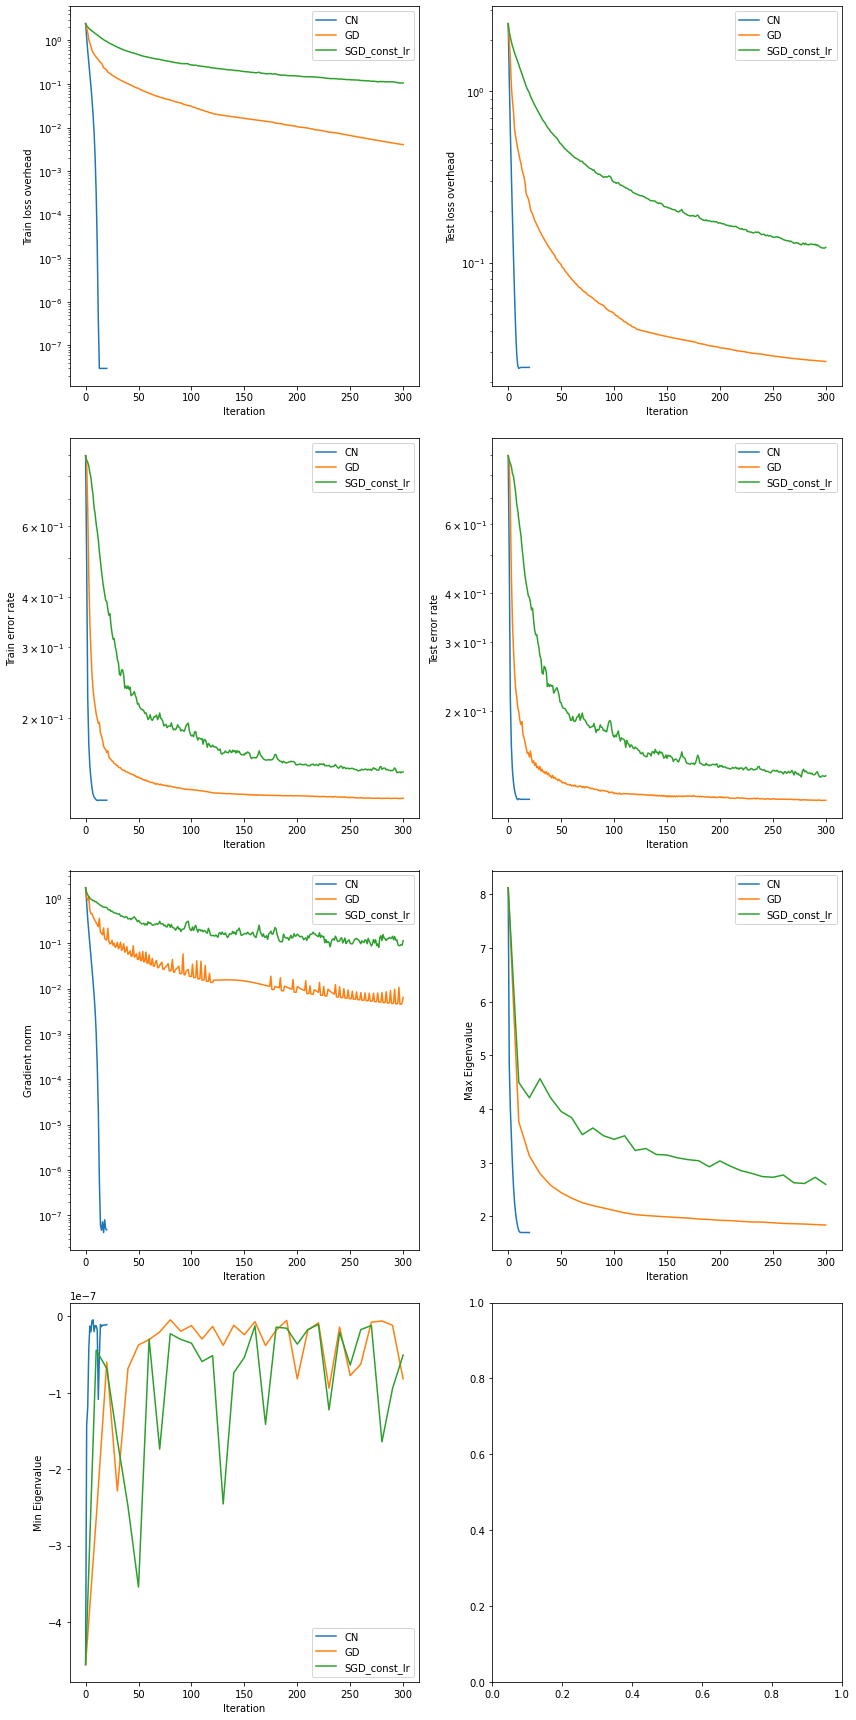

In [27]:
fig, ax = plt.subplots(4,2, figsize=(12,24))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"] - MIN_TRAIN_LOSS, label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="GD")
#ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD")
ax[0,0].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD_const_lr")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss overhead")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"] - MIN_TEST_LOSS, label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"] - MIN_TEST_LOSS, label="GD")
#ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD")
ax[0,1].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD_const_lr")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss overhead")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
#ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].plot(SGD_const_lr_metrics["iter"], 1 - SGD_const_lr_metrics["train_acc"], label="SGD_const_lr")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
#ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].plot(SGD_const_lr_metrics["iter"], 1 - SGD_const_lr_metrics["test_acc"], label="SGD_const_lr")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
#ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["grad_norm"], label="SGD_const_lr")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

ax[2,1].plot(CN_metrics["hessian_iter"], CN_metrics["lambda_1"], label="CN")
ax[2,1].plot(GD_metrics["hessian_iter"], GD_metrics["lambda_1"], label="GD")
#ax[2,1].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,1].plot(SGD_const_lr_metrics["hessian_iter"], SGD_const_lr_metrics["lambda_1"], label="SGD_const_lr")
ax[2,1].set_xlabel("Iteration")
ax[2,1].set_ylabel("Max Eigenvalue")
#ax[2,1].set_yscale('log')
ax[2,1].legend()

ax[3,0].plot(CN_metrics["hessian_iter"], CN_metrics["lambda_n"], label="CN")
ax[3,0].plot(GD_metrics["hessian_iter"], GD_metrics["lambda_n"], label="GD")
#ax[3,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[3,0].plot(SGD_const_lr_metrics["hessian_iter"], SGD_const_lr_metrics["lambda_n"], label="SGD_const_lr")
ax[3,0].set_xlabel("Iteration")
ax[3,0].set_ylabel("Min Eigenvalue")
#ax[3,0].set_yscale('log')
ax[3,0].legend()

fig.tight_layout()
plt.show()

### 1-hidden layer Neural Network

In [9]:
PATH = os.path.join(os.getcwd(), "saved_calc\\two_layers_NN")

if not os.path.isdir(PATH):
    os.makedirs(PATH)

In [10]:
new_dim = 10

net = MLP([new_dim, 10, 2], torch.relu)

loss_function = nn.CrossEntropyLoss()

def get_net():
    return copy.deepcopy(net)

def get_dataset():
    dataset = load_and_transform_mnist(new_dim)
    # tranforming labels to binary to reduce model size
    dataset["train_targets"] = transform_labels_to_binary(dataset["train_targets"])
    dataset["test_targets"] = transform_labels_to_binary(dataset["test_targets"])
    return dataset

In [11]:
results_file = "SGD_const_lr_metrics.pkl"
max_iters = 200
print_every = 100
eval_every = 10
eval_hessian_every = None
retrain = True
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
b_size = 128

SGD_const_lr_metrics = train(CustomTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, OptimizerClass=optim_class,
                             optimizer_params=optim_params, batch_size=b_size)

Retraining model:

     0: train loss =  0.893777, time =    0.00 sec
   100: train loss =  0.470889, time =    0.05 sec
   200: train loss =  0.369180, time =    0.09 sec


In [13]:
results_file = "GD_metrics.pkl"
max_iters = 200
print_every = 100
eval_every = 10
eval_hessian_every = None
retrain = True
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

GD_metrics = train(AdaptiveGDTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, L_0=Lipschitz_const, L_min=Lipschitz_const_min)

Retraining model:

     0: train loss =  0.760279, L =    1.000, time =    0.00 sec
   100: train loss =  0.347342, L =    2.000, time =    3.48 sec
   200: train loss =  0.308019, L =    4.000, time =    6.73 sec


In [21]:
results_file = "CN_metrics.pkl"
max_iters = 100
print_every = 10
eval_every = 1
eval_hessian_every = 1
retrain = False
# kwargs
Lipschitz_const = 1.0
Lipschitz_const_min = 0.001

CN_metrics = train(AdaptiveCubicNewtonTrainer, get_net, get_dataset, loss_function, results_file, max_iters,
          print_every, eval_every, eval_hessian_every, retrain, M_0=Lipschitz_const, M_min=Lipschitz_const_min)

Training statistics was already calculated before:

     0: train loss =  0.833872, M =    1.000, time =    0.00 sec, lambda_1 =     13.13412, lambda_n =    -1.085747
    10: train loss =  0.553995, M =   32.000, time =   13.76 sec, lambda_1 =     17.45094, lambda_n =    -0.280964
    20: train loss =  0.503153, M =   32.000, time =   28.70 sec, lambda_1 =     22.56958, lambda_n =    -0.330330
    30: train loss =  0.430837, M =   64.000, time =   43.43 sec, lambda_1 =     32.00657, lambda_n =    -0.365675
    40: train loss =  0.393882, M =   64.000, time =   61.74 sec, lambda_1 =     40.19596, lambda_n =    -0.451154
    50: train loss =  0.370862, M =  512.000, time =   79.22 sec, lambda_1 =     47.04481, lambda_n =    -0.563515
    60: train loss =  0.355252, M =  256.000, time =   96.62 sec, lambda_1 =     51.74150, lambda_n =    -0.666401
    70: train loss =  0.341471, M =  128.000, time =  113.88 sec, lambda_1 =     55.59939, lambda_n =    -0.700579
    80: train loss =  0.3322

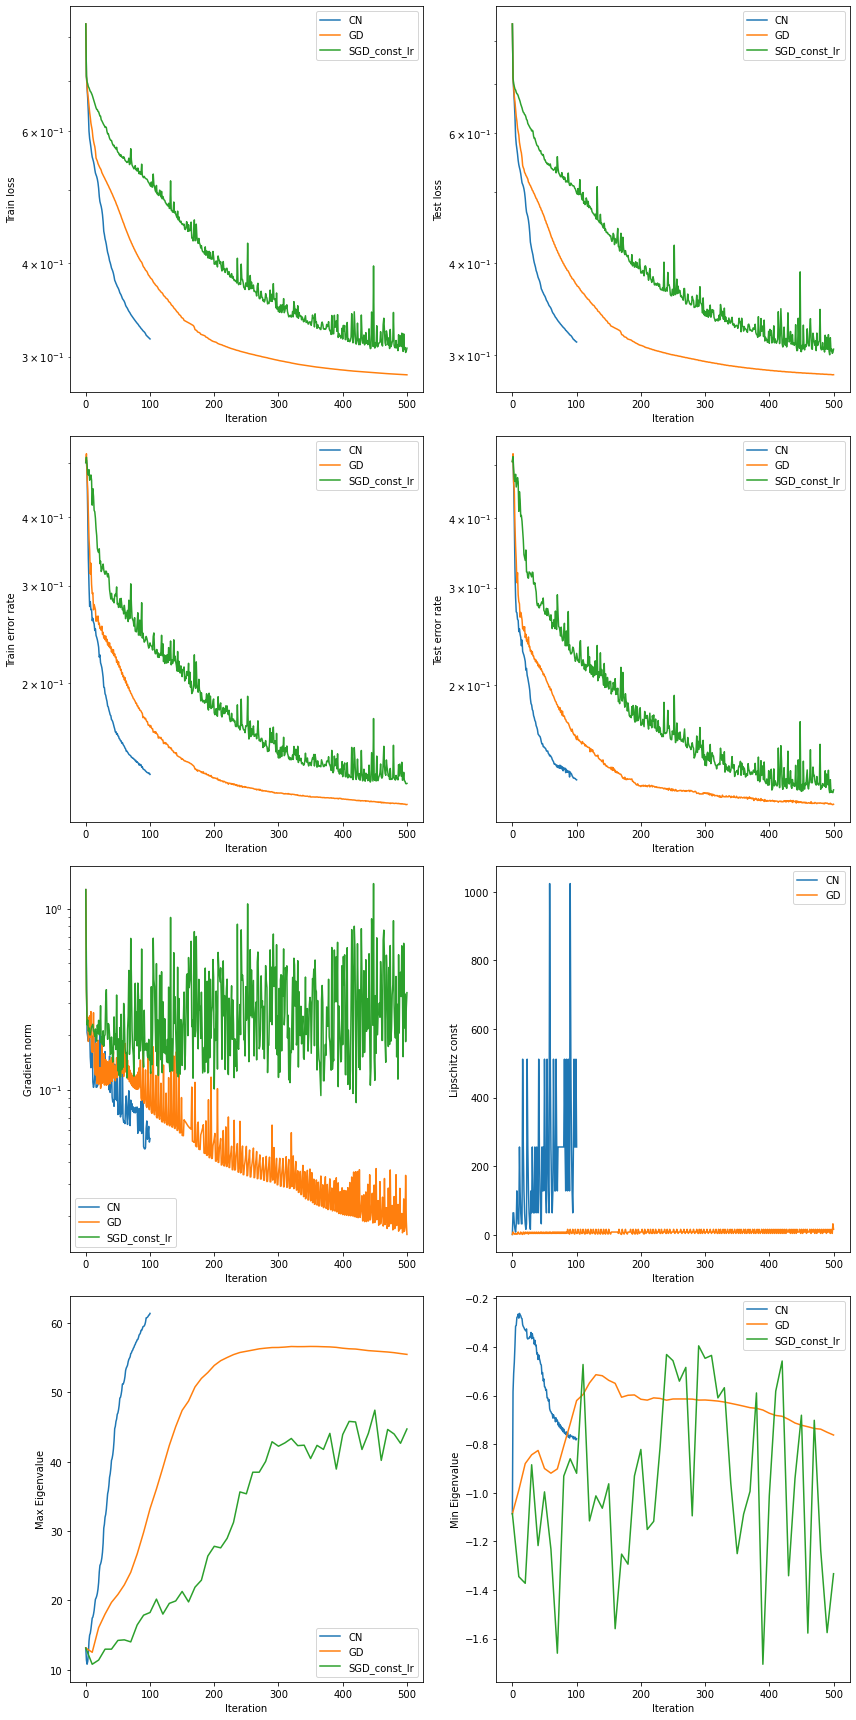

In [22]:
fig, ax = plt.subplots(4,2, figsize=(12,24))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
#ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"] - MIN_TRAIN_LOSS, label="SGD")
ax[0,0].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["train_loss"], label="SGD_const_lr")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
#ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"] - MIN_TEST_LOSS, label="SGD")
ax[0,1].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["test_loss"], label="SGD_const_lr")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
#ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].plot(SGD_const_lr_metrics["iter"], 1 - SGD_const_lr_metrics["train_acc"], label="SGD_const_lr")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
#ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].plot(SGD_const_lr_metrics["iter"], 1 - SGD_const_lr_metrics["test_acc"], label="SGD_const_lr")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
#ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].plot(SGD_const_lr_metrics["iter"], SGD_const_lr_metrics["grad_norm"], label="SGD_const_lr")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

ax[2,1].plot(CN_metrics["iter"], CN_metrics["M"], label="CN")
ax[2,1].plot(GD_metrics["iter"], GD_metrics["L"], label="GD")
ax[2,1].set_xlabel("Iteration")
ax[2,1].set_ylabel("Lipschitz const")
#ax[2,1].set_yscale('log')
ax[2,1].legend()

ax[3,0].plot(CN_metrics["hessian_iter"], CN_metrics["lambda_1"], label="CN")
ax[3,0].plot(GD_metrics["hessian_iter"], GD_metrics["lambda_1"], label="GD")
#ax[3,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[3,0].plot(SGD_const_lr_metrics["hessian_iter"], SGD_const_lr_metrics["lambda_1"], label="SGD_const_lr")
ax[3,0].set_xlabel("Iteration")
ax[3,0].set_ylabel("Max Eigenvalue")
#ax[3,0].set_yscale('log')
ax[3,0].legend()

ax[3,1].plot(CN_metrics["hessian_iter"], CN_metrics["lambda_n"], label="CN")
ax[3,1].plot(GD_metrics["hessian_iter"], GD_metrics["lambda_n"], label="GD")
#ax[3,1].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[3,1].plot(SGD_const_lr_metrics["hessian_iter"], SGD_const_lr_metrics["lambda_n"], label="SGD_const_lr")
ax[3,1].set_xlabel("Iteration")
ax[3,1].set_ylabel("Min Eigenvalue")
#ax[3,1].set_yscale('log')
ax[3,1].legend()

fig.tight_layout()
plt.show()

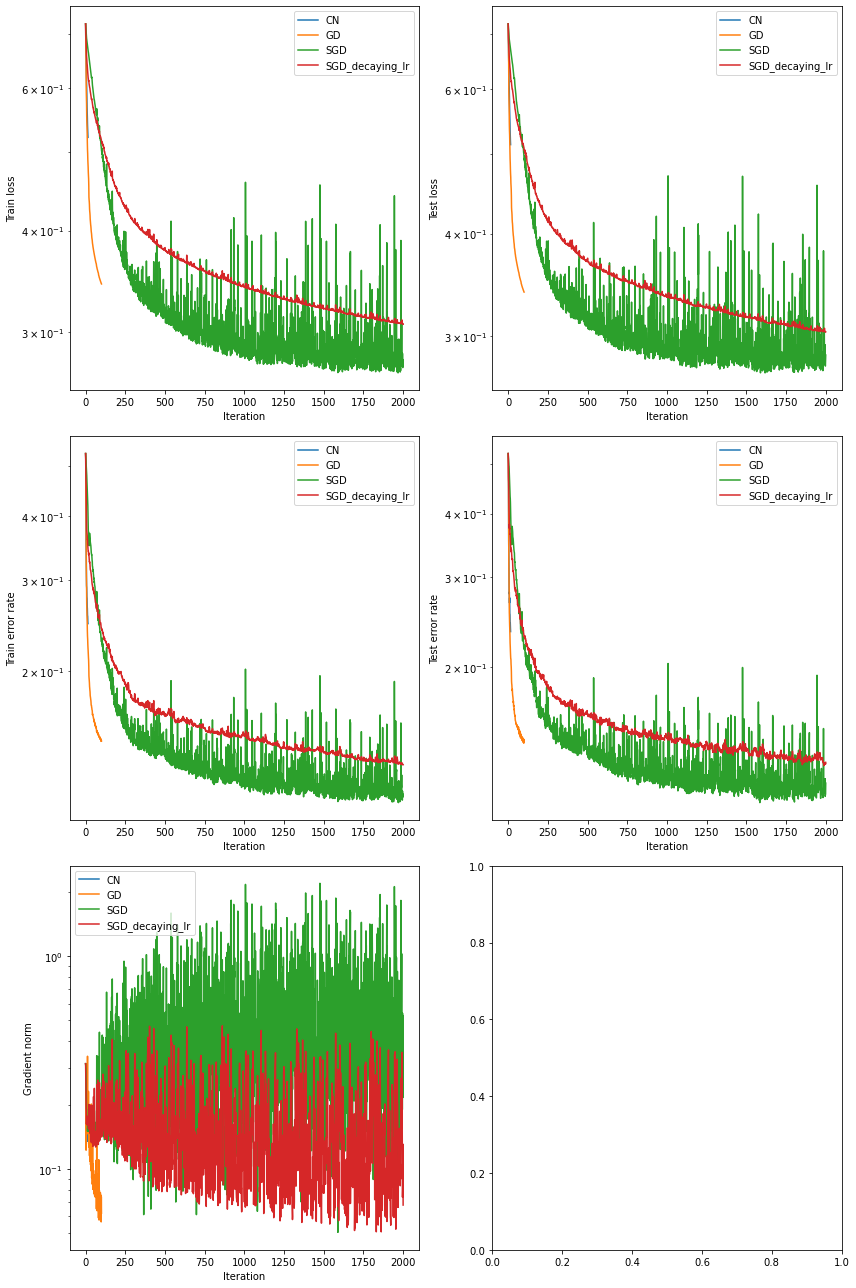

In [46]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"], label="SGD")
ax[0,0].plot(SGD_decaying_lr_metrics["iter"], SGD_decaying_lr_metrics["train_loss"], label="SGD_decaying_lr")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"], label="SGD")
ax[0,1].plot(SGD_decaying_lr_metrics["iter"], SGD_decaying_lr_metrics["test_loss"], label="SGD_decaying_lr")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].plot(SGD_decaying_lr_metrics["iter"], 1 - SGD_decaying_lr_metrics["train_acc"], label="SGD_decaying_lr")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].plot(SGD_decaying_lr_metrics["iter"], 1 - SGD_decaying_lr_metrics["test_acc"], label="SGD_decaying_lr")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].plot(SGD_decaying_lr_metrics["iter"], SGD_decaying_lr_metrics["grad_norm"], label="SGD_decaying_lr")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()

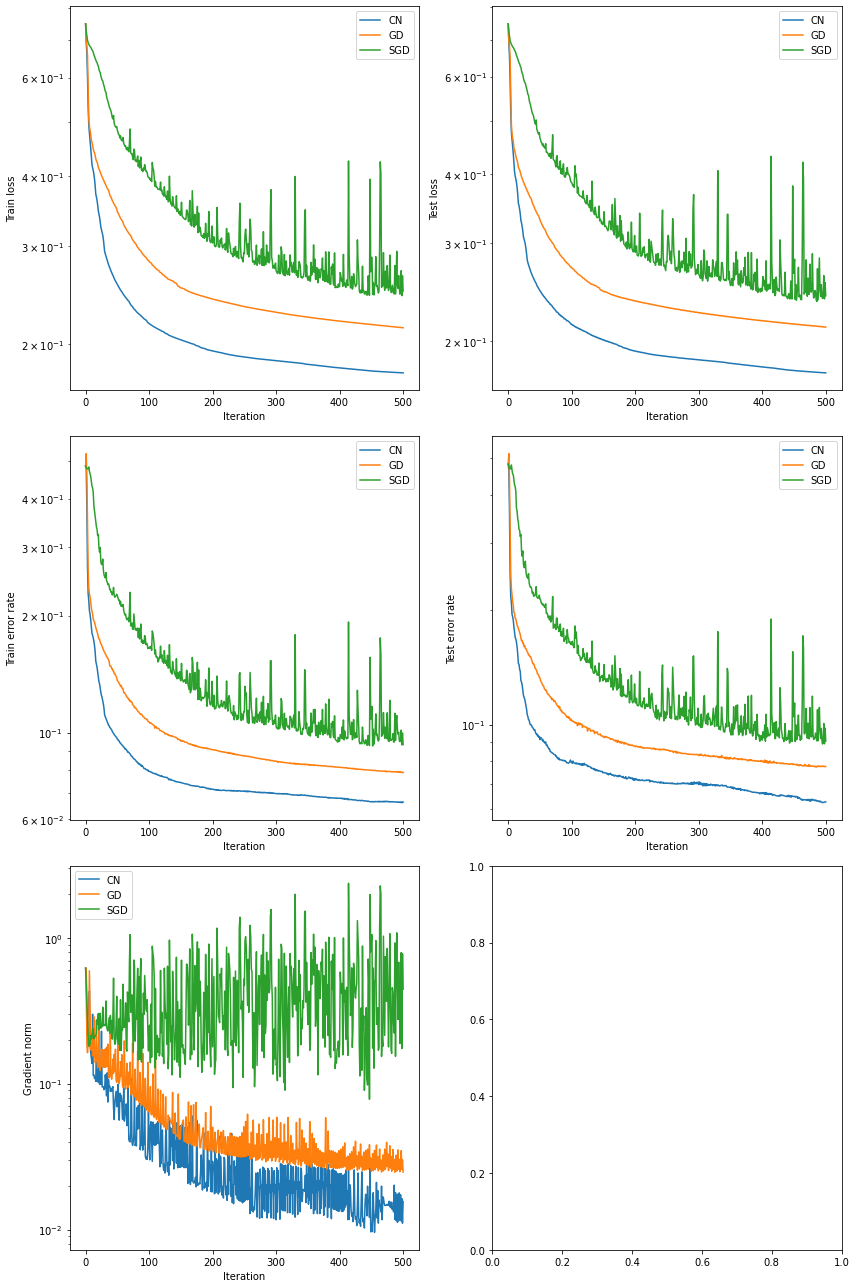

In [38]:
fig, ax = plt.subplots(3,2, figsize=(12,18))

ax[0,0].plot(CN_metrics["iter"], CN_metrics["train_loss"], label="CN")
ax[0,0].plot(GD_metrics["iter"], GD_metrics["train_loss"], label="GD")
ax[0,0].plot(SGD_metrics["iter"], SGD_metrics["train_loss"], label="SGD")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("Train loss")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(CN_metrics["iter"], CN_metrics["test_loss"], label="CN")
ax[0,1].plot(GD_metrics["iter"], GD_metrics["test_loss"], label="GD")
ax[0,1].plot(SGD_metrics["iter"], SGD_metrics["test_loss"], label="SGD")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("Test loss")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(CN_metrics["iter"], 1 - CN_metrics["train_acc"], label="CN")
ax[1,0].plot(GD_metrics["iter"], 1 - GD_metrics["train_acc"], label="GD")
ax[1,0].plot(SGD_metrics["iter"], 1 - SGD_metrics["train_acc"], label="SGD")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("Train error rate")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(CN_metrics["iter"], 1 - CN_metrics["test_acc"], label="CN")
ax[1,1].plot(GD_metrics["iter"], 1 - GD_metrics["test_acc"], label="GD")
ax[1,1].plot(SGD_metrics["iter"], 1 - SGD_metrics["test_acc"], label="SGD")
ax[1,1].set_xlabel("Iteration")
ax[1,1].set_ylabel("Test error rate")
ax[1,1].set_yscale('log')
ax[1,1].legend()

ax[2,0].plot(CN_metrics["iter"], CN_metrics["grad_norm"], label="CN")
ax[2,0].plot(GD_metrics["iter"], GD_metrics["grad_norm"], label="GD")
ax[2,0].plot(SGD_metrics["iter"], SGD_metrics["grad_norm"], label="SGD")
ax[2,0].set_xlabel("Iteration")
ax[2,0].set_ylabel("Gradient norm")
ax[2,0].set_yscale('log')
ax[2,0].legend()

fig.tight_layout()
plt.show()

<AxesSubplot:>

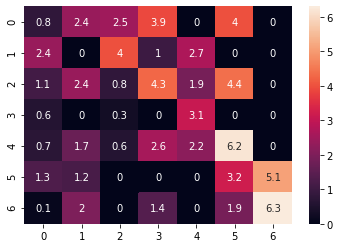

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

# plt.imshow(harvest)
sns.heatmap(harvest, annot=True)